# Dependencies

In [243]:
%%capture
!pip install pandas
!pip install pyarrow
!pip install tensorflow
!pip install protobuf==3.20.*
!pip install mediapipe==0.9.0.1

In [268]:
import os
import json
import shutil
import random
import matplotlib
import numpy as np
from itertools import chain
from collections import deque
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from collections import Counter
from matplotlib import animation, rc
from IPython.display import display, Image

import cv2
import pandas as pd
import mediapipe as mp
import tensorflow as tf
from tensorflow import keras
import pyarrow.parquet as pq
from tensorflow.keras import layers
from mediapipe.framework.formats import landmark_pb2

In [245]:
!python --version
print("TensorFlow v" + tf.__version__)
print("Mediapipe v" + mp.__version__)

Python 3.9.13
TensorFlow v2.14.0
Mediapipe v0.9.0.1


In [246]:
random.seed(42)

# Load data

In [11]:
dataset_df = pd.read_csv('kaggle_dataset/train.csv')
print("Full train dataset shape is {}".format(dataset_df.shape))

Full train dataset shape is (67208, 5)


In [12]:
dataset_df.head()

,path,file_id,sequence_id,participant_id,phrase
0,train_landmarks/5414471.parquet,5414471,1816796431,217,3 creekhouse
1,train_landmarks/5414471.parquet,5414471,1816825349,107,scales/kuhaylah
2,train_landmarks/5414471.parquet,5414471,1816909464,1,1383 william lanier
3,train_landmarks/5414471.parquet,5414471,1816967051,63,988 franklin lane
4,train_landmarks/5414471.parquet,5414471,1817123330,89,6920 northeast 661st road


In [13]:
def random_sequence():
    # Fetch sequence_id, file_id, phrase from first row
    sequence_id, file_id, phrase, path = dataset_df.sample(n=1).iloc[0][['sequence_id', 'file_id', 'phrase', 'path']]
    print(f"sequence_id: {sequence_id}, file_id: {file_id}, phrase: {phrase}")
    
    # Fetch data from parquet file
    sample_sequence_df = pq.read_table(f"kaggle_dataset/{path}",
        filters=[[('sequence_id', '=', sequence_id)],]).to_pandas()
    print("Full sequence dataset shape is {}".format(sample_sequence_df.shape))
    
    return sample_sequence_df

In [14]:
random_sequence()

sequence_id: 598828087, file_id: 1255240050, phrase: 4707 east north 5th street
Full sequence dataset shape is (257, 1630)


,frame,x_face_0,x_face_1,x_face_2,x_face_3,x_face_4,x_face_5,x_face_6,x_face_7,x_face_8,...,z_right_hand_11,z_right_hand_12,z_right_hand_13,z_right_hand_14,z_right_hand_15,z_right_hand_16,z_right_hand_17,z_right_hand_18,z_right_hand_19,z_right_hand_20
sequence_id,,,,,,,,,,,,,,,,,,,,,
598828087,0,0.635422,0.618059,0.626171,0.606184,0.616039,0.616736,0.621383,0.528805,0.621075,...,-0.176701,-0.197007,-0.137643,-0.182106,-0.210568,-0.232459,-0.156701,-0.205694,-0.231554,-0.250193
598828087,1,0.634529,0.617514,0.625708,0.605696,0.615494,0.616232,0.621088,0.527717,0.620918,...,-0.180136,-0.205396,-0.105569,-0.157280,-0.193206,-0.215042,-0.117593,-0.167984,-0.190830,-0.203019
598828087,2,0.631605,0.617696,0.625954,0.606129,0.615712,0.616562,0.621718,0.527976,0.621656,...,-0.143433,-0.165293,-0.090447,-0.136625,-0.173426,-0.195574,-0.109981,-0.159163,-0.181790,-0.193255
598828087,3,0.630961,0.617825,0.626130,0.606422,0.615874,0.616765,0.621974,0.529141,0.622006,...,-0.128644,-0.150045,-0.080953,-0.115954,-0.147751,-0.168680,-0.095641,-0.129537,-0.145586,-0.154983
598828087,4,0.633035,0.617995,0.626315,0.606662,0.616064,0.616977,0.622198,0.530145,0.622104,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
598828087,252,0.631806,0.623763,0.633085,0.613513,0.621742,0.623091,0.629779,0.540662,0.629925,...,-0.110351,-0.100256,-0.028981,-0.102971,-0.094699,-0.065803,-0.043567,-0.091914,-0.083012,-0.060308
598828087,253,0.633409,0.623467,0.633199,0.614227,0.621589,0.623353,0.631173,0.543561,0.631833,...,-0.110364,-0.100653,-0.032455,-0.103338,-0.095984,-0.068953,-0.045893,-0.092428,-0.084708,-0.063777
598828087,254,0.635777,0.627601,0.637084,0.618718,0.625862,0.627758,0.635860,0.546159,0.636807,...,-0.109583,-0.101533,-0.036960,-0.100667,-0.091854,-0.066618,-0.050763,-0.090222,-0.080589,-0.059869


## Animation preview

In [15]:
matplotlib.rcParams['animation.embed_limit'] = 2**128
matplotlib.rcParams['savefig.pad_inches'] = 0
rc('animation', html='jshtml')

def create_animation(images):
    fig = plt.figure(figsize=(6, 9))
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    im=ax.imshow(images[0], cmap="gray")
    plt.close(fig)
    
    def animate_func(i):
        im.set_array(images[i])
        return [im]

    return animation.FuncAnimation(fig, animate_func, frames=len(images), interval=1000/10)

mp_pose = mp.solutions.pose
mp_hands = mp.solutions.hands
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils 
mp_drawing_styles = mp.solutions.drawing_styles

def collect_landmarks_oftype(_type: str, frame_data: pd.Series):
    x_type = frame_data.filter(regex=f"x_{_type}.*").values
    y_type = frame_data.filter(regex=f"y_{_type}.*").values
    z_type = frame_data.filter(regex=f"z_{_type}.*").values
    landmarks = landmark_pb2.NormalizedLandmarkList()
    for x, y, z in zip(x_type, y_type, z_type):
        landmarks.landmark.add(x=x, y=y, z=z)
    return landmarks
        
def produce_video_from_seq(seq_df: pd.DataFrame):
    frames = []
    for seq_idx in range(len(seq_df)):
        frame = np.zeros((600, 600, 3))
        frame_data = seq_df.iloc[seq_idx]
        
        # Right hand
        right_hand_landmarks = collect_landmarks_oftype("right_hand", frame_data)
        mp_drawing.draw_landmarks(
                frame,
                right_hand_landmarks,
                mp_hands.HAND_CONNECTIONS,
                landmark_drawing_spec=mp_drawing_styles.get_default_hand_landmarks_style())
        
        # Left Hand
        left_hand_landmarks = collect_landmarks_oftype("left_hand", frame_data)
        mp_drawing.draw_landmarks(
                frame,
                left_hand_landmarks,
                mp_hands.HAND_CONNECTIONS,
                landmark_drawing_spec=mp_drawing_styles.get_default_hand_landmarks_style())
        
        # Face
        face_landmarks = collect_landmarks_oftype("face", frame_data)
        mp_drawing.draw_landmarks(
            frame,
            face_landmarks,
            mp_holistic.FACEMESH_CONTOURS,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp_drawing_styles
            .get_default_face_mesh_contours_style())
        
        # Pose
        pose_landmarks = collect_landmarks_oftype("pose", frame_data)
        mp_drawing.draw_landmarks(
            frame,
            pose_landmarks,
            mp_holistic.POSE_CONNECTIONS,
            landmark_drawing_spec=mp_drawing_styles.
            get_default_pose_landmarks_style())
        
        frames.append(frame.astype(np.uint8))
    return frames

In [16]:
video = produce_video_from_seq(random_sequence())
create_animation(video)

sequence_id: 1926120986, file_id: 1365772051, phrase: 1311 palmyra port gibson
Full sequence dataset shape is (39, 1630)


# Statistics

In [75]:
def lengths_hist(lengths: list, title="", space=50):
    plt.hist(lengths, np.linspace(0, space, space))
    plt.ylim(plt.ylim())
    max_length = max(lengths)
    plt.plot([max_length, max_length], plt.ylim())
    plt.title(f'{title} (Max: {max_length})')
    plt.show()

def calc_percentiles(values: list, percentiles=[25, 50,75, 80, 90]):
    percentile_values = np.percentile(values, percentiles)
    for p, value in zip(percentiles, percentile_values):
        print(f"{p}th percentile: {value}")

## Statistics on the length of phrases:

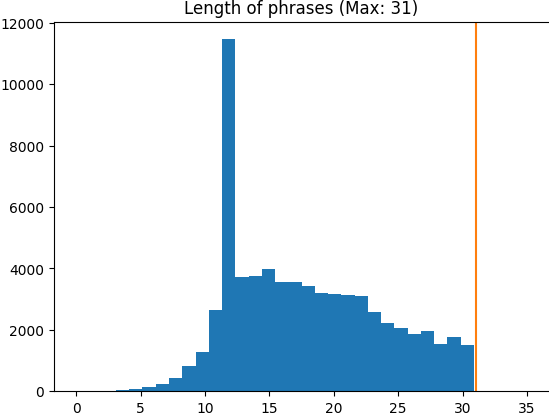

25th percentile: 12.0
50th percentile: 17.0
75th percentile: 22.0
80th percentile: 23.0
90th percentile: 27.0


In [76]:
phrase_lengths = []
def gather_lenghts(phrase: str):
    phrase_lengths.append(len(phrase))
    return phrase
dataset_df.phrase.apply(gather_lenghts)

lengths_hist(phrase_lengths, "Length of phrases", 35)
calc_percentiles(phrase_lengths)

## Statistics on the length of sequences:

  0%|          | 0/68 [00:00<?, ?it/s]

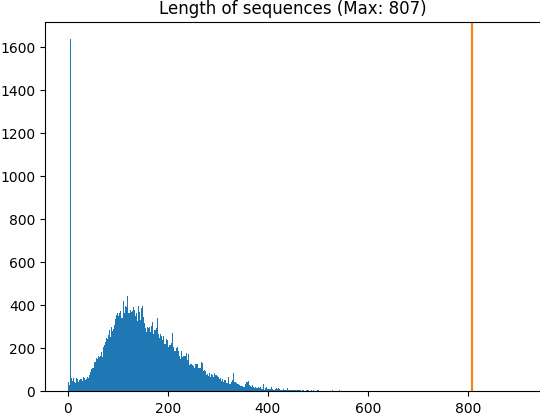

25th percentile: 104.0
50th percentile: 148.0
75th percentile: 207.0
80th percentile: 223.0
90th percentile: 270.0


In [78]:
seq_lengths = []
for file_path in tqdm(dataset_df.path.unique()):
    pq_file = f"kaggle_dataset/{file_path}"
    seq_lengths.extend(list(pq.read_table(pq_file,columns=['sequence_id']).to_pandas().index.to_series().value_counts()))

lengths_hist(seq_lengths, "Length of sequences", 900)

calc_percentiles(seq_lengths)

What's interesting to note is that there are many cases where the sequence is only a few frames long. This would be normal if the phrase associated with the sequence also a had short length. But the statistics about the phrase lengths show that there aren't as many.
Also from the animation preview, it is clear that in many frames the detailed hand landmarks are not available.

To fix these issues a heuristic needs to be applied:
    - Calculate how many frames the dominant hand is visible
    - Require at least two frames per character in the associated phrase

  0%|          | 0/68 [00:00<?, ?it/s]

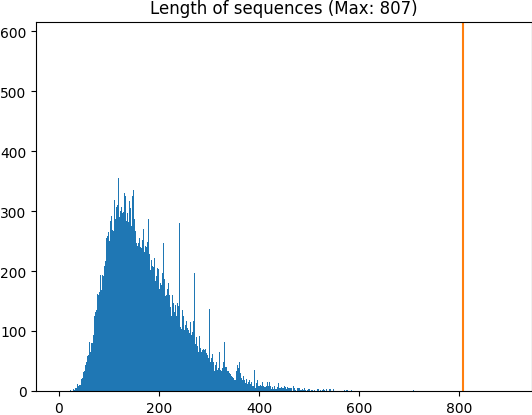

25th percentile: 104.0
50th percentile: 148.0
75th percentile: 207.0
80th percentile: 223.0
90th percentile: 270.0


In [79]:
seq_lengths_filtered = []
for file_path in tqdm(dataset_df.path.unique()):
    pq_file = f"kaggle_dataset/{file_path}"
    # For some reason the next two lines cannot be placed in a single line as it results in an error
    # If anyone figures out what can cause that contact me:)
    parquet_df = pq.read_table(pq_file, columns=['sequence_id'] + FEATURE_COLUMNS).to_pandas()
    parquet_numpy = parquet_df.to_numpy()
    
    parts = file_path.split('/')
    last_part = parts[-1]
    number_string = last_part.split('.')[0]
    file_id = int(number_string)
    
    # Filter train.csv and fetch entries only for the relevant file_id
    file_df = dataset_df.loc[dataset_df["file_id"] == file_id]
    
    for seq_id, phrase in zip(file_df.sequence_id, file_df.phrase):
        # Fetch sequence data
        frames = parquet_numpy[parquet_df.index == seq_id]
        # Calculate the number of rows that only have NaN values -> on how many frames each hand is fully visible
        r_nonan = np.sum(np.sum(np.isnan(frames[:, RHAND_IDX]), axis = 1) == 0)
        l_nonan = np.sum(np.sum(np.isnan(frames[:, LHAND_IDX]), axis = 1) == 0)
        # Number of frames where the dominant hand is visible (dominant = visible on more frames than the other hand)
        num_of_visible = max(r_nonan, l_nonan)
        # TODO experiment with this
        if 2*len(phrase) < num_of_visible:
            seq_lengths_filtered.append(len(frames))

lengths_hist(seq_lengths_filtered, "Length of sequences", 900)
calc_percentiles(seq_lengths)

The models input will be the padded sequences. It's an iteresting optimization task as cutting off at lower lengths wastes data, but saves computation time.

# Save to TFRecords

In [81]:
# Pose coordinates for hand movement.
LPOSE = [13, 15, 17, 19, 21]
RPOSE = [14, 16, 18, 20, 22]
POSE = LPOSE + RPOSE

X = [f'x_right_hand_{i}' for i in range(21)] + [f'x_left_hand_{i}' for i in range(21)] + [f'x_pose_{i}' for i in POSE]
Y = [f'y_right_hand_{i}' for i in range(21)] + [f'y_left_hand_{i}' for i in range(21)] + [f'y_pose_{i}' for i in POSE]
Z = [f'z_right_hand_{i}' for i in range(21)] + [f'z_left_hand_{i}' for i in range(21)] + [f'z_pose_{i}' for i in POSE]

FEATURE_COLUMNS = X + Y + Z

X_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if "x_" in col]
Y_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if "y_" in col]
Z_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if "z_" in col]

RHAND_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if "right" in col]
LHAND_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if  "left" in col]
RPOSE_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if  "pose" in col and int(col[-2:]) in RPOSE]
LPOSE_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if  "pose" in col and int(col[-2:]) in LPOSE]

In [82]:
def save_tfrecords_to(folder: str):
    # Loop through each file_id
    for file_path in tqdm(dataset_df.path.unique()):
        # Parquet file name
        pq_file = f"kaggle_dataset/{file_path}"
        
        parts = file_path.split('/')
        last_part = parts[-1]
        number_string = last_part.split('.')[0]
        file_id = int(number_string)
        
        # Filter train.csv and fetch entries only for the relevant file_id
        file_df = dataset_df.loc[dataset_df["file_id"] == file_id]
        # Fetch the parquet file
        parquet_df = pq.read_table(pq_file,columns=['sequence_id'] + FEATURE_COLUMNS).to_pandas()

        # File name for the updated data
        tf_file = f"{folder}/{file_id}.tfrecord"
        parquet_numpy = parquet_df.to_numpy()
        # Initialize the pointer to write the output of each `for loop` below as a sequence into the file.
        with tf.io.TFRecordWriter(tf_file) as file_writer:
            # Loop through each sequence in file.
            for seq_id, phrase in zip(file_df.sequence_id, file_df.phrase):
                # Fetch sequence data
                frames = parquet_numpy[parquet_df.index == seq_id]

                # Calculate the number of rows that only have NaN values -> on how many frames each hand is fully visible
                r_nonan = np.sum(np.sum(np.isnan(frames[:, RHAND_IDX]), axis = 1) == 0)
                l_nonan = np.sum(np.sum(np.isnan(frames[:, LHAND_IDX]), axis = 1) == 0)
                # Number of frames where the dominant hand is visible (dominant = visible on more frames than the other hand)
                num_of_visible = max(r_nonan, l_nonan)

                # TODO experiment with this
                if 2*len(phrase) < num_of_visible:
                    features = {FEATURE_COLUMNS[i]: tf.train.Feature(float_list=tf.train.FloatList(value=frames[:, i])) for i in range(len(FEATURE_COLUMNS))}
                    features["phrase"] = tf.train.Feature(bytes_list=tf.train.BytesList(value=[bytes(phrase, 'utf-8')]))
                    record_bytes = tf.train.Example(features=tf.train.Features(feature=features)).SerializeToString()
                    file_writer.write(record_bytes)

In [83]:
folder_name = "train_tfrecords"
if not os.path.isdir(folder_name):
    os.mkdir(folder_name)
    save_tfrecords_to(folder_name)
else:
    print(f"Warning: Tfrecords already exist! Delete the {folder_name} folder to regenerate them!")

# Fetch from TFRecords

In [84]:
tf_records = dataset_df.file_id.map(lambda x: f'{folder_name}/{x}.tfrecord').unique()
print(f"List of {len(tf_records)} TFRecord files.")

List of 68 TFRecord files.


In [104]:
# The default mapping that came with the dataset was changed:
# padding is represented with the number 0
# start_token is 60
# end_token is 61
with open ("kaggle_dataset/character_to_prediction_index.json", "r") as f:
    char_to_num = json.load(f)

# Add pad_token, start pointer and end pointer to the dict
pad_token = 'P'
start_token = '<'
end_token = '>'
pad_token_idx = char_to_num[pad_token]
start_token_idx = char_to_num[start_token]
end_token_idx = char_to_num[end_token]

num_to_char = {j:i for i,j in char_to_num.items()}

In [105]:
def decode_fn(record_bytes):
    schema = {COL: tf.io.VarLenFeature(dtype=tf.float32) for COL in FEATURE_COLUMNS}
    schema["phrase"] = tf.io.FixedLenFeature([], dtype=tf.string)
    features = tf.io.parse_single_example(record_bytes, schema)
    phrase = features["phrase"]
    landmarks = ([tf.sparse.to_dense(features[COL]) for COL in FEATURE_COLUMNS])
    # Transpose to maintain the original shape of landmarks data.
    landmarks = tf.transpose(landmarks)
    
    return landmarks, phrase

In [205]:
FRAME_LEN = 256
MAX_PHRASE_LEN = 32

# Function to resize and add padding.
def resize_pad(x):
    if tf.shape(x)[0] < FRAME_LEN:
        x = tf.pad(x, ([[0, FRAME_LEN-tf.shape(x)[0]], [0, 0], [0, 0]]))
    else:
        x = tf.image.resize(x, (FRAME_LEN, tf.shape(x)[1]))
    return x

# Detect the dominant hand from the number of NaN values.
# Dominant hand will have less NaN values since it is in frame moving.
def pre_process(x):
    rhand = tf.gather(x, RHAND_IDX, axis=1)
    lhand = tf.gather(x, LHAND_IDX, axis=1)
    rpose = tf.gather(x, RPOSE_IDX, axis=1)
    lpose = tf.gather(x, LPOSE_IDX, axis=1)
    
    rnan_idx = tf.reduce_any(tf.math.is_nan(rhand), axis=1)
    lnan_idx = tf.reduce_any(tf.math.is_nan(lhand), axis=1)
    
    rnans = tf.math.count_nonzero(rnan_idx)
    lnans = tf.math.count_nonzero(lnan_idx)
    
    # For dominant hand
    if rnans > lnans:
        hand = lhand
        pose = lpose
        
        hand_x = hand[:, 0*(len(LHAND_IDX)//3) : 1*(len(LHAND_IDX)//3)]
        hand_y = hand[:, 1*(len(LHAND_IDX)//3) : 2*(len(LHAND_IDX)//3)]
        hand_z = hand[:, 2*(len(LHAND_IDX)//3) : 3*(len(LHAND_IDX)//3)]
        hand = tf.concat([1-hand_x, hand_y, hand_z], axis=1)
        
        pose_x = pose[:, 0*(len(LPOSE_IDX)//3) : 1*(len(LPOSE_IDX)//3)]
        pose_y = pose[:, 1*(len(LPOSE_IDX)//3) : 2*(len(LPOSE_IDX)//3)]
        pose_z = pose[:, 2*(len(LPOSE_IDX)//3) : 3*(len(LPOSE_IDX)//3)]
        pose = tf.concat([1-pose_x, pose_y, pose_z], axis=1)
    else:
        hand = rhand
        pose = rpose
    
    hand_x = hand[:, 0*(len(LHAND_IDX)//3) : 1*(len(LHAND_IDX)//3)]
    hand_y = hand[:, 1*(len(LHAND_IDX)//3) : 2*(len(LHAND_IDX)//3)]
    hand_z = hand[:, 2*(len(LHAND_IDX)//3) : 3*(len(LHAND_IDX)//3)]
    hand = tf.concat([hand_x[..., tf.newaxis], hand_y[..., tf.newaxis], hand_z[..., tf.newaxis]], axis=-1)
    
    mean = tf.math.reduce_mean(hand, axis=1)[:, tf.newaxis, :]
    std = tf.math.reduce_std(hand, axis=1)[:, tf.newaxis, :]
    hand = (hand - mean) / std

    pose_x = pose[:, 0*(len(LPOSE_IDX)//3) : 1*(len(LPOSE_IDX)//3)]
    pose_y = pose[:, 1*(len(LPOSE_IDX)//3) : 2*(len(LPOSE_IDX)//3)]
    pose_z = pose[:, 2*(len(LPOSE_IDX)//3) : 3*(len(LPOSE_IDX)//3)]
    pose = tf.concat([pose_x[..., tf.newaxis], pose_y[..., tf.newaxis], pose_z[..., tf.newaxis]], axis=-1)
    
    x = tf.concat([hand, pose], axis=1)
    x = resize_pad(x)
    
    x = tf.where(tf.math.is_nan(x), tf.zeros_like(x), x)
    x = tf.reshape(x, (FRAME_LEN, len(LHAND_IDX) + len(LPOSE_IDX)))
    return x

table = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(
        keys=list(char_to_num.keys()),
        values=list(char_to_num.values()),
    ),
    default_value=tf.constant(-1),
    name="class_weight"
)

def convert_fn(landmarks, phrase):
    # Add start and end pointers to phrase.
    phrase = start_token + phrase + end_token
    phrase = tf.strings.bytes_split(phrase)
    phrase = table.lookup(phrase)
    
    max_len_plus = MAX_PHRASE_LEN + 1
    amount_to_pad = max_len_plus - tf.shape(phrase)[0]
    
    if amount_to_pad > 0:
        phrase = tf.pad(phrase, paddings=[[0, amount_to_pad]], mode = 'CONSTANT', constant_values = pad_token_idx)
    else:
        phrase = phrase[:max_len_plus]
    
    return (pre_process(landmarks), phrase[:-1]), phrase[1:]

In [206]:
batch_size = 32
train_len = int(0.8 * len(tf_records))
shuffle_buffer_size = 4*batch_size

train_ds = tf.data.TFRecordDataset(tf_records[:train_len]).map(decode_fn).map(convert_fn).batch(batch_size).shuffle(buffer_size=shuffle_buffer_size).prefetch(buffer_size=tf.data.AUTOTUNE).cache()
valid_ds = tf.data.TFRecordDataset(tf_records[train_len:]).map(decode_fn).map(convert_fn).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE).cache()

In [207]:
lm_shape = None
phrase_shape = None

# Create an iterator for the train and valid datasets
train_iterator = iter(train_ds)

# Print data points from the training dataset
print("Training Data:\n")
(landmarks, context), phrase = next(train_iterator)

# Save shapes
lm_shape = landmarks.shape[2]
phrase_shape = phrase.shape[0]
print("Saved shapes:")
print(f"lm_shape: {lm_shape}")
print(f"phrase_shape: {phrase_shape}")
print("-" * 40)

print("Encoder input (Landmarks:)")
print(type(landmarks))
print(landmarks.shape)
print(landmarks[0])
print("-" * 40)

print("Decoder input (Context):")
print(context.shape)
print(context[0])
print("-" * 40)

print("Model target output (Phrase):")
print(phrase.shape)
print(phrase[0])
print("-" * 40)

Training Data:

Saved shapes:
lm_shape: 78
phrase_shape: 32
----------------------------------------
Encoder input (Landmarks:)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(32, 256, 78)
tf.Tensor(
[[-0.3814261   2.2412903   2.5202641  ...  0.1865588   0.77009904
  -3.4876022 ]
 [-0.34241447  2.4138293   2.3249927  ...  0.18907848  0.7043939
  -3.3339748 ]
 [-0.39776525  2.4920106   2.0805104  ...  0.19723839  0.6763937
  -3.3899055 ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]], shape=(256, 78), dtype=float32)
----------------------------------------
Decoder input (Context):
(32, 32)
tf.Tensor(
[60 23 22 20 24  1 36 37 46 41 47 61  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0], shape=(32,), dtype=int32)
----------------------------------------
Model target output (Phrase):
(32, 32)
tf

# Creating the Model

In [300]:
# https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/transformer.ipynb#scrollTo=1Rz82wEs5biZ

def positional_encoding(length, depth):
    depth = depth/2

    positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
    depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)
    
    angle_rates = 1 / (10000**depths)         # (1, depth)
    angle_rads = positions * angle_rates      # (pos, depth)

    pos_encoding = np.concatenate(
        [np.sin(angle_rads), np.cos(angle_rads)],
        axis=-1) 

    return tf.cast(pos_encoding, dtype=tf.float32)

class PositionalTokenEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, d_model, max_future_input_size):
        super().__init__()
        self.d_model = d_model
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)
        self.pos_encoding = positional_encoding(length=max_future_input_size, depth=d_model)

    def compute_mask(self, *args, **kwargs):
        return self.embedding.compute_mask(*args, **kwargs)

    def call(self, x):
        length = tf.shape(x)[1]
        x = self.embedding(x)
        # This factor sets the relative scale of the embedding and positonal_encoding.
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x = x + self.pos_encoding[tf.newaxis, :length, :]
        return x

class PositionalLandmarkEmbedding(tf.keras.layers.Layer):
    def __init__(self, len_of_seq, d_model, num_conv_layers, filter_size):
        super().__init__()
        self.d_model = d_model
        self.len_of_seq = len_of_seq
        # maybe add input for Convs
        self.conv_block = tf.keras.models.Sequential([
            tf.keras.layers.Conv1D(d_model, filter_size, padding="same", activation="relu")
            for _ in range(num_conv_layers)
        ])
        self.pos_encoding = positional_encoding(length=len_of_seq, depth=d_model)
        
    def call(self, x):
        #length = tf.shape(x)[1]
        x = self.conv_block(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        # print(self.pos_encoding[tf.newaxis, :self.len_of_seq, :].shape) # (1, 128, 512) this isnt semantically correct
        x = x + self.pos_encoding[tf.newaxis, :self.len_of_seq, :]
        return x
    
class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

class CrossAttention(BaseAttention):
    def call(self, x, context):
        attn_output, attn_scores = self.mha(
            query=x,
            key=context,
            value=context,
            return_attention_scores=True)
       
        # Cache the attention scores for plotting later.
        self.last_attn_scores = attn_scores
    
        x = self.add([x, attn_output])
        x = self.layernorm(x)
    
        return x
    
class GlobalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(
            query=x,
            value=x,
            key=x)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x
    
class CausalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(
            query=x,
            value=x,
            key=x,
            use_causal_mask = True)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x
    
class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate=0.1):
        super().__init__()
        self.seq = tf.keras.Sequential([
          tf.keras.layers.Dense(dff, activation='relu'),
          tf.keras.layers.Dense(d_model),
          tf.keras.layers.Dropout(dropout_rate)
        ])
        self.add = tf.keras.layers.Add()
        self.layer_norm = tf.keras.layers.LayerNormalization()

    def call(self, x):
        x = self.add([x, self.seq(x)])
        x = self.layer_norm(x) 
        return x
    
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
        super().__init__()
    
        self.self_attention = GlobalSelfAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)
    
        self.ffn = FeedForward(d_model, dff)
    
    def call(self, x):
        x = self.self_attention(x)
        x = self.ffn(x)
        return x
    
class Encoder(tf.keras.layers.Layer):
    def __init__(self, *, len_of_seq, num_layers, d_model, num_heads,
               dff, num_conv_layers, filter_size, dropout_rate=0.1):
        super().__init__()
    
        self.d_model = d_model
        self.num_layers = num_layers
    
        self.pos_embedding = PositionalLandmarkEmbedding(
            len_of_seq, d_model, num_conv_layers, filter_size)
    
        self.enc_layers = [
            EncoderLayer(d_model=d_model,
                         num_heads=num_heads,
                         dff=dff,
                         dropout_rate=dropout_rate)
            for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x):
        # `x` is landmark sequences with shape: (batch, seq_len, features)
        x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.
        
        x = self.dropout(x)
    
        for i in range(self.num_layers):
            x = self.enc_layers[i](x)
    
        return x  # Shape `(batch_size, seq_len, d_model)`.
    
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, *, d_model, num_heads, dff, dropout_rate=0.1):
        super(DecoderLayer, self).__init__()
    
        self.causal_self_attention = CausalSelfAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)
        
        self.cross_attention = CrossAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)
    
        self.ffn = FeedForward(d_model, dff)

    def call(self, x, context):
        x = self.causal_self_attention(x=x)
        x = self.cross_attention(x=x, context=context)
    
        # Cache the last attention scores for plotting later
        self.last_attn_scores = self.cross_attention.last_attn_scores
    
        x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
        return x
    
class Decoder(tf.keras.layers.Layer):
    def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size, max_future_input_size, dropout_rate=0.1):
        super(Decoder, self).__init__()
    
        self.d_model = d_model
        self.num_layers = num_layers
    
        self.pos_embedding = PositionalTokenEmbedding(vocab_size=vocab_size, d_model=d_model, max_future_input_size=max_future_input_size)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.dec_layers = [
            DecoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate)
            for _ in range(num_layers)]
    
        self.last_attn_scores = None

    def call(self, x, context):
        # `x` is token-IDs shape (batch, target_seq_len)
        x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)
    
        x = self.dropout(x)
    
        for i in range(self.num_layers):
            x  = self.dec_layers[i](x, context)
    
        self.last_attn_scores = self.dec_layers[-1].last_attn_scores
    
        # The shape of x is (batch_size, target_seq_len, d_model).
        return x
    
class Transformer(tf.keras.Model):
    def __init__(self, *, len_lm_seq, num_enc_layers, num_conv_layers, filter_size, num_dec_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, max_future_input_size, dropout_rate=0.1):
        super().__init__()
        self.encoder = Encoder(len_of_seq=len_lm_seq,
                               num_layers=num_enc_layers, d_model=d_model,
                               num_heads=num_heads, dff=dff,
                               num_conv_layers=num_conv_layers,
                               filter_size=filter_size,
                               dropout_rate=dropout_rate)
        
        self.decoder = Decoder(num_layers=num_dec_layers, d_model=d_model,
                               num_heads=num_heads, dff=dff,
                               vocab_size=target_vocab_size,
                               max_future_input_size=max_future_input_size,
                               dropout_rate=dropout_rate)
    
        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inputs):
        # To use a Keras model with `.fit` you must pass all your inputs in the
        # first argument.
        landmark_seq, prev_gen_context  = inputs
    
        encoded_lm_seq = self.encoder(landmark_seq)  # (batch_size, landmark_seq_len, d_model)
        x = self.decoder(prev_gen_context, encoded_lm_seq)  # (batch_size, target_len, d_model)
        logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

        try:
            # Drop the keras mask, so it doesn't scale the losses/metrics.
            # b/250038731
            del logits._keras_mask
        except AttributeError:
            pass
    
        return logits

In [301]:
d_model = 200 # embedding size
max_future_input_size = MAX_PHRASE_LEN  # In the future the input can be longer than what it's trained on

transformer = Transformer(
    len_lm_seq=FRAME_LEN,
    num_enc_layers=2,
    num_conv_layers=3,
    filter_size=11,
    num_dec_layers=1,
    d_model=d_model,
    num_heads=4,
    dff=200, 
    input_vocab_size=len(char_to_num),
    target_vocab_size=len(char_to_num),
    max_future_input_size=max_future_input_size,
    dropout_rate=0.1)

In [302]:
# Example inference to build the model
(lm, ctx), _label = next(iter(train_ds))
output = transformer((lm, ctx))

print(lm.shape)
print(ctx.shape)
print(output.shape)

transformer.summary()

(32, 256, 78)
(32, 32)
(32, 32, 62)
Model: "transformer_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_5 (Encoder)         multiple                  2499800   
                                                                 
 decoder_5 (Decoder)         multiple                  1379200   
                                                                 
 dense_38 (Dense)            multiple                  12462     
                                                                 
Total params: 3891462 (14.84 MB)
Trainable params: 3891462 (14.84 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [303]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()
    
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
    
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
    
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

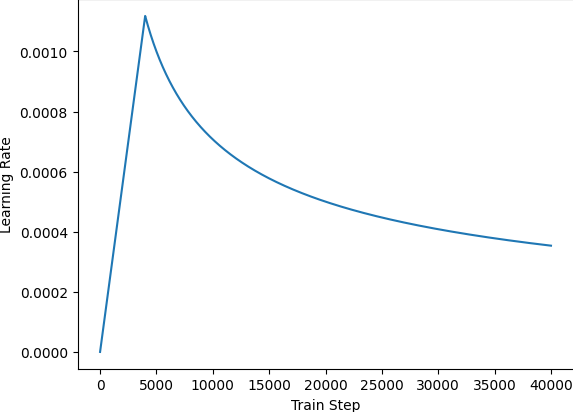

In [304]:
learning_rate = CustomSchedule(d_model)

plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

In [305]:
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

In [306]:
def masked_loss(label, pred):
    mask = label != pad_token_idx
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
    loss = loss_object(label, pred)

    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask

    loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
    return loss


def masked_accuracy(label, pred):
    pred = tf.argmax(pred, axis=2)
    label = tf.cast(label, pred.dtype)
    match = label == pred

    mask = label != pad_token_idx

    match = match & mask

    match = tf.cast(match, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [307]:
transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

In [308]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='model_checkpoint',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

In [ ]:
%%time
transformer.fit(train_ds,
                validation_data=valid_ds,
                epochs=30,
                callbacks=[checkpoint_callback],
                verbose = 2)

Epoch 1/30


In [151]:
# Manual inference on test input
test_inp = np.zeros((1, FRAME_LEN, lm_shape))
test_ctx = np.array([[start_token_idx]])
logits = transformer((test_inp, test_ctx))
pred_idx = np.argmax(tf.nn.softmax(logits)[0][0])
num_to_char[pred_idx]

','

In [178]:
tf_chars = tf.constant(list(char_to_num.keys()), dtype=tf.string)
tf_nums = tf.constant(list(char_to_num.values()), dtype=tf.int64)

class FingerSpellingTransformer(tf.Module):
    def __init__(self, model: Transformer):
        super(FingerSpellingTransformer, self).__init__()
        self.model = model
        
        self.tf_char_to_num = tf.lookup.StaticHashTable(
            initializer=tf.lookup.KeyValueTensorInitializer(
                keys=tf_chars,
                values=tf_nums,
            ),
            default_value=tf.constant(-1, dtype=tf.int64),
            name="tf_char_to_num_lut"
        )
        
        self.tf_num_to_char = tf.lookup.StaticHashTable(
            initializer=tf.lookup.KeyValueTensorInitializer(
                keys=tf_nums,
                values=tf_chars,
            ),
            default_value=tf.constant("unknown", dtype=tf.string),
            name="tf_num_to_char_lut"
        )

        self.ctx_len = tf.constant(max_future_input_size, dtype=tf.int32)

    @tf.function(input_signature=[
        tf.TensorSpec(shape=[tf.constant(FRAME_LEN), tf.constant(lm_shape)], dtype=tf.float32),
        tf.TensorSpec(shape=[], dtype=tf.string), # The input string is trimmed to max size set when initializing model
    ])
    def predict(self, landmarks, ctx):
        # Prepare input
        ctx_length = tf.strings.length(ctx)
        starting_pos = tf.maximum(ctx_length - self.ctx_len, 0)
        ctx = tf.strings.substr(ctx, starting_pos, self.ctx_len)
        
        ctx_chars = tf.strings.unicode_split(ctx, input_encoding='UTF-8')
        ctx_tokens = self.tf_char_to_num.lookup(ctx_chars)
        batched_ctx_tokens = tf.expand_dims(ctx_tokens, axis=0) # Adds first ("batch") dimension to the tensor
        batched_landmarks = tf.expand_dims(landmarks, axis=0)
        
        # Inference
        logits = self.model((batched_landmarks, batched_ctx_tokens))
        
        # Parse result
        probabilities = tf.nn.softmax(logits)[0][0]
        pred_prob = tf.reduce_max(probabilities)
        pred_idx = tf.argmax(probabilities)
        pred_char = self.tf_num_to_char.lookup(pred_idx)
        
        return {'result' : pred_char, 'confidence': pred_prob}

In [179]:
transformer_wrapper = FingerSpellingTransformer(transformer)

In [194]:
%%time
transformer_wrapper.predict(np.zeros((FRAME_LEN, lm_shape)), "abc")

CPU times: total: 78.1 ms
Wall time: 25.7 ms


{'result': <tf.Tensor: shape=(), dtype=string, numpy=b'e'>,
 'confidence': <tf.Tensor: shape=(), dtype=float32, numpy=0.2392772>}

In [200]:
save_model_name = "saved_model"
if os.path.isdir(save_model_name):
    print(f"A model with the same name has already been saved!")
else:
    tf.saved_model.save(transformer_wrapper, export_dir=save_model_name)

INFO:tensorflow:Assets written to: saved_model\assets


INFO:tensorflow:Assets written to: saved_model\assets


# Testing

## On Test dataset

In [269]:
loaded_model = tf.saved_model.load("saved_model")

In [270]:
def generate(model, inp, max_len):
    ctx = str(num_to_char[start_token_idx])
    for i in range(max_len):
        res = model.predict(inp, ctx)
        res_char = res["result"].numpy().decode("utf-8")
        ctx += res_char

        if res_char == num_to_char[end_token_idx]:
            break
    return ctx

def generate_teacher_forcing(model, inp, expected):
    pred = str(num_to_char[start_token_idx])
    ctx = str(num_to_char[start_token_idx])
    for e in expected:
        res = model.predict(inp, ctx)
        res_char = res["result"].numpy().decode("utf-8")
        pred += res_char
        ctx += e
    return pred

In [240]:
batches = [batch for batch in valid_ds]

for (inp_batch, _ctx), expected_batch in batches[:1]:
    for seq, expected in zip(inp_batch, expected_batch):
        expected = "".join([num_to_char[num.numpy()] for num in expected])
        gen_on_won = generate(loaded_model, seq, MAX_PHRASE_LEN)
        gen_with_teacher_forcing = generate_teacher_forcing(loaded_model, seq, expected)
        
        print("Expected: " + expected)
        print("Generated on own: " + gen_on_won)
        print("Generate teacher forcing: " + gen_with_teacher_forcing)
        print('\n~~~\n')

Expected: 2796 west golden willow drive>PP
Generated on own: <qqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqq
Generate teacher forcing: <qqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqq

~~~

Expected: 973-471-9887>PPPPPPPPPPPPPPPPPPP
Generated on own: <qqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqq
Generate teacher forcing: <qqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqq

~~~

Expected: 497-723-6992>PPPPPPPPPPPPPPPPPPP
Generated on own: <qqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqq
Generate teacher forcing: <qqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqq

~~~

Expected: reallyloud.co.uk/simaii>PPPPPPPP
Generated on own: <qqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqq
Generate teacher forcing: <qqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqq

~~~

Expected: kkaicd1.pixnet.net>PPPPPPPPPPPPP
Generated on own: <qqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqq
Generate teacher forcing: <qqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqq

~~~

Expected: 8260 john r bowdoin>PPPPPPPPPPPP
Generated on own: <qqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqq
Generate teacher forcing: <qqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqq

~~~

Expected: 56 paper birch drive>PPP

## Real life testing

In [253]:
def draw_landmarks_on_image(image, results):
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    mp_drawing.draw_landmarks(
        image,
        results.face_landmarks,
        mp_holistic.FACEMESH_CONTOURS,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp_drawing_styles
        .get_default_face_mesh_contours_style())
    mp_drawing.draw_landmarks(
        image,
        results.pose_landmarks,
        mp_holistic.POSE_CONNECTIONS,
        landmark_drawing_spec=mp_drawing_styles
        .get_default_pose_landmarks_style())
    mp_drawing.draw_landmarks(
        image,
        results.left_hand_landmarks,
        mp_holistic.HAND_CONNECTIONS,
        landmark_drawing_spec=mp_drawing_styles.get_default_hand_landmarks_style()
    )
    mp_drawing.draw_landmarks(
        image,
        results.right_hand_landmarks,
        mp_holistic.HAND_CONNECTIONS,
        landmark_drawing_spec=mp_drawing_styles.get_default_hand_landmarks_style()
    )
    return image

In [250]:
def extract_from_result(res):
    # Extract specific pose landmarks if available
    px = []
    py = []
    pz = []
    if res.pose_landmarks:
        for i in POSE:
            lm = res.pose_landmarks.landmark[i]
            px.append(lm.x)
            py.append(lm.y)
            pz.append(lm.z)
    else:
        px = [0.0]*len(POSE)
        py = [0.0]*len(POSE)
        pz = [0.0]*len(POSE)

    # Extract left hand landmarks if available
    lx = []
    ly = []
    lz = []
    if res.left_hand_landmarks:
        for lm in res.left_hand_landmarks.landmark:
            lx.append(lm.x)
            ly.append(lm.y)
            lz.append(lm.z)
    else:
        lx = [0.0]*21
        ly = [0.0]*21
        lz = [0.0]*21

    # Extract right hand landmarks if available
    rx = []
    ry = []
    rz = []
    if res.right_hand_landmarks:
        for lm in res.right_hand_landmarks.landmark:
            rx.append(lm.x)
            ry.append(lm.y)
            rz.append(lm.z)
    else:
        rx = [0.0]*21
        ry = [0.0]*21
        rz = [0.0]*21

    return list(chain(rx, lx, px, ry, ly, py, rz, lz, pz))

In [271]:
signing_detection_model = tf.saved_model.load("signing_detection_model")
signing_detection_model_input = list(np.zeros((15, 156)))

def is_signing(inp_lm):
    signing_detection_model_input.pop(0)
    signing_detection_model_input.append(inp_lm)
    return signing_detection_model.predict(signing_detection_model_input)["result"].numpy() == 1

In [289]:
loaded_transformer_model = tf.saved_model.load("saved_model")
loaded_transformer_model_input = []
inner_fifo = deque(maxlen=10)
confidence_number = 7
trust_confidence = 0.2
inp_len = 15
context = str(num_to_char[start_token_idx])

def run_model(inp_lm):
    global context
    
    if len(loaded_transformer_model_input) >= inp_len:
        loaded_transformer_model_input.pop(0)
    loaded_transformer_model_input.append(inp_lm)
    
    inp = pre_process(loaded_transformer_model_input)
    res = loaded_transformer_model.predict(inp, context)
    pred = res["result"].numpy().decode("utf-8")
    prob = res["confidence"].numpy()

    if prob < trust_confidence:
        return

    inner_fifo.append(pred)
    pred_char, count = Counter(inner_fifo).most_common(1)[0]
    if count >= confidence_number:
        if context[-1] != pred_char:
            context += pred_char
            print(pred_char, end="")
            
            # Predicted the end
            if pred_char == '>':
                # restart the detection
                context = str(num_to_char[start_token_idx])
                inner_fifo.clear()
                print("\\n")

In [290]:
video = cv2.VideoCapture(0)
display_handle=display(None, display_id=True)
try:
    with mp_holistic.Holistic(min_detection_confidence=0.5,min_tracking_confidence=0.5) as holistic:
        while True:
            _, frame = video.read()

            if frame is None:
                break

            #image = cv2.resize(frame, (360, 240))
            image=frame

            # To improve performance, optionally mark the image as not writeable to pass by reference.
            image.flags.writeable = False
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            results = holistic.process(image)
            data = extract_from_result(results)
            
            if is_signing(data):
                print("*", end="")
                run_model(data)

            # Draw landmark annotation on the image.
            image = draw_landmarks_on_image(image, results)

            image = cv2.flip(image, 1)
            _, image = cv2.imencode('.jpeg', image)
            display_handle.update(Image(data=image.tobytes()))
except KeyboardInterrupt:
    pass
finally:
    video.release()
    display_handle.update(None)

None

*******q***********************************************************************************************************************************************************************************************************************************************************************************************************************************************

# Later cells are not refined

In [46]:
# Többségi döntéses kiértékelés with signing detection

# camera - 0
# video - "path/to/file"
file_or_camera = "bear.mp4"

from collections import Counter
from collections import deque

inner_fifo = deque(maxlen=10)
confidence_number = 7
INP_LEN = 15
signing_detection_model_input = list(np.zeros((INP_LEN, 156)))
model_data = []
last_output = start_token_idx
whole_pred = ""

def process_model_output(new_output: int):
    global last_output
    global whole_pred
    
    whole_pred += idx_to_char[new_output]
    
    inner_fifo.append(new_output)
    
    predicted_idx, count = Counter(inner_fifo).most_common(1)[0]
    if count >= confidence_number:
        if last_output != predicted_idx:
            last_output = predicted_idx
            
            # Predicted the end
            if predicted_idx == end_token_idx:
                # restart the detection
                last_output = start_token_idx
                inner_fifo.clear()
                print("\\n")
            else:
                print(idx_to_char[predicted_idx], end="")


video = cv2.VideoCapture(file_or_camera)
display_handle=display(None, display_id=True)
try:
    with mp_holistic.Holistic(min_detection_confidence=0.5,min_tracking_confidence=0.5) as holistic:
        while True:
            _, frame = video.read()

            if frame is None:
                break

            # Resize the frame to the target width and height
            image = cv2.resize(frame, (360, 240))

            # To improve performance, optionally mark the image as not writeable to
            # pass by reference.
            image.flags.writeable = False
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            results = holistic.process(image)
            data = extract_from_result(results)
            
            signing_detection_model_input.pop(0)
            signing_detection_model_input.append(data)
            
#             is_signing = np.argmax(is_signing_model.predict(np.array([signing_detection_model_input]), verbose=0)) == 1
#             if is_signing:
#                 print("*", end="")
#                 if len(model_data) >= INP_LEN:
#                     model_data.pop(0)
#                 model_data.append(data)
#                 inp = pre_process(model_data)
#                 preds = model.generate_precisely(np.array([inp]), last_output, 1)
#                 process_model_output(preds[0, 1].numpy())
#             else:
#                 print("-", end="")

            if len(model_data) >= INP_LEN:
                model_data.pop(0)
            model_data.append(data)
            inp = pre_process(model_data)
            preds = model.generate_precisely(np.array([inp]), last_output, 1)
            process_model_output(preds[0, 1].numpy())
            

            # Draw landmark annotation on the image.
#             image.flags.writeable = True
#             image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
#             mp_drawing.draw_landmarks(
#                 image,
#                 results.face_landmarks,
#                 mp_holistic.FACEMESH_CONTOURS,
#                 landmark_drawing_spec=None,
#                 connection_drawing_spec=mp_drawing_styles
#                 .get_default_face_mesh_contours_style())

#             mp_drawing.draw_landmarks(
#                 image,
#                 results.pose_landmarks,
#                 mp_holistic.POSE_CONNECTIONS,
#                 landmark_drawing_spec=mp_drawing_styles
#                 .get_default_pose_landmarks_style())

#             mp_drawing.draw_landmarks(
#                 image,
#                 results.left_hand_landmarks,
#                 mp_holistic.HAND_CONNECTIONS,
#                 landmark_drawing_spec=mp_drawing_styles.get_default_hand_landmarks_style()
#             )

#             mp_drawing.draw_landmarks(
#                 image,
#                 results.right_hand_landmarks,
#                 mp_holistic.HAND_CONNECTIONS,
#                 landmark_drawing_spec=mp_drawing_styles.get_default_hand_landmarks_style()
#             )

            #frame = cv2.flip(image, 1)
            _, frame = cv2.imencode('.jpeg', image)
            display_handle.update(Image(data=frame.tobytes()))
except KeyboardInterrupt:
    pass
finally:
    video.release()
    display_handle.update(None)

None

beloun

In [49]:
# várjunk amíg megtelik egy frame aztán pred greedy módon

model_data = []
video = cv2.VideoCapture("whale.mp4")
display_handle=display(None, display_id=True)
try:
    with mp_holistic.Holistic(min_detection_confidence=0.5,min_tracking_confidence=0.5) as holistic:
        while True:
            _, frame = video.read()
            
            if frame is None:
                break

            # Resize the frame to the target width and height
            image = cv2.resize(frame, (360, 240))

            # To improve performance, optionally mark the image as not writeable to
            # pass by reference.
            image.flags.writeable = False
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            results = holistic.process(image)
            data = extract_from_result(results)
            if len(model_data) == 100:
                print("Frames filled up")
                break
                
            model_data.append(data)
           
            # Draw landmark annotation on the image.
            image.flags.writeable = True
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
            mp_drawing.draw_landmarks(
                image,
                results.face_landmarks,
                mp_holistic.FACEMESH_CONTOURS,
                landmark_drawing_spec=None,
                connection_drawing_spec=mp_drawing_styles
                .get_default_face_mesh_contours_style())

            mp_drawing.draw_landmarks(
                image,
                results.pose_landmarks,
                mp_holistic.POSE_CONNECTIONS,
                landmark_drawing_spec=mp_drawing_styles
                .get_default_pose_landmarks_style())

            mp_drawing.draw_landmarks(
                image,
                results.left_hand_landmarks,
                mp_holistic.HAND_CONNECTIONS,
                landmark_drawing_spec=mp_drawing_styles.get_default_hand_landmarks_style()
            )

            mp_drawing.draw_landmarks(
                image,
                results.right_hand_landmarks,
                mp_holistic.HAND_CONNECTIONS,
                landmark_drawing_spec=mp_drawing_styles.get_default_hand_landmarks_style()
            )

            #frame = cv2.flip(image, 1)
            _, frame = cv2.imencode('.jpeg', image)
            display_handle.update(Image(data=frame.tobytes()))
except KeyboardInterrupt:
    pass
finally:
    video.release()
    display_handle.update(None)
    

# Run the model
inp = pre_process(model_data)
preds = model.generate(np.array([inp]), start_token_idx)
prediction = ""
for idx in preds[0, 1:]:
    prediction += idx_to_char[idx]
    last_char = idx_to_char[idx]
    if idx == end_token_idx:
        break
        
prediction

None

Frames filled up


'whe whal a lew ho>'

In [219]:
# Változtatások:
# *teljes alakos kirajzolás
# *positional encoding eredmények jobbak lettek:
#     <2796 west golden willow drive>
#     <279796 west gollen willow drive>
#     ~~~
#     <973-471-9887>
#     <+44-21-41-99>
#     ~~~
#     <497-723-6992>
#     <497-723-6928>
#     ~~~
#     <reallyloud.co.uk/simaii>
#     <realloud.com.ru/simai>
#     ~~~
#     <kkaicd1.pixnet.net>
#     <aicol-pig-ponet>
#     ~~~
#     <8260 john r bowdoin>
#     <820 johnrbowdoin>
#     ~~~
#     <56 paper birch drive>
#     <566 penbirch rdive>
#     ~~~
#     <gand-chudai-hardcor.html>
#     <randandingarcarcer.com.com.tk>
#     ~~~
#     <2708 west 77th>
#     <2708 west7th>
#     ~~~
#     <https://www.keainfo.gr>
#     <https://www.kreafo.hth>
#     ~~~
#     <288 fuller lake>
#     <28858 forlanerl>
#     ~~~
#     <mser/oki-guide>
#     <mser/okide>
#     ~~~
#     <220 north 47th avenue east>
#     <20 north panust peareas>
#     ~~~
#     <www.sudinfo.be>
#     <www.suturafa.com>
#     ~~~
#     <69 grant point>
#     <6691 paroira>
#     ~~~
#     <fibrain.pl/chapter-145/thanghr>
#     <fibrain-1choter-4lan.hau>
#     ~~~
#     <+351-521-8895>
#     <+335-3572-895>
#     ~~~
#     <via-piero-gobetti/brandi-love>
#     <vingiera-gro-betindi.ndi.ve>
#     ~~~
#     <amir le>
#     <amoir le>
#     ~~~
#     <automantenimiento-sa>
#     <monymimiento-to-sa>
#     ~~~
#     <6499 nfd 5053>
#     <649-998-5053>
#     ~~~
#     <7870 preston place>
#     <9753 parroplangl plane>
#     ~~~
#     <6870 scabisuit lane>
#     <6870 scabisuisuit lane>
#     ~~~
#     <sunshine mayer>
#     <sutrashines/mayer>
#     ~~~
#     <408-249-4707>
#     <487-823-4430>
#     ~~~
#     <arabradio.us/vana>
#     <arabrasdio.rs/vana>
#     ~~~
#     <televisoresponse>
#     <60146000009>
#     ~~~
#     <www.voices.com/bitesize>
#     <www.voropes.com/besit>
#     ~~~
#     <qd.razavi.ac.ir/bunya>
#     <stda-da-vir-acirra>
#     ~~~
#     <+246-987-50-80-02-294>
#     <+246-987-50-80-80294>
#     ~~~
# *classification modellt nem sikerült betanítani továbbra sem
# (más modellekkel is próbálkoztam azok sem mentek, szóval valahogy az adattal lehet gond)
# találtam másik adathalmazt is hozzá következőkben nem 250 hanem sokkal kevesebb signt fogok neki betanítani
# *real worlddel való összekötés sikerei? olvasd tovább:
#     Kísérletek:
#     van előre egy szekvencia, és azt kell fordítani, az egész jól megy
#     ha viszont egy folyamatos videóból kell ráadásul egymással nem kapcsolatban lévő részeket fordítani az nem az igazi
#     1. ötlet: mindig egy újabb karaktert generálunk, és egy fifóból többségi döntéssel prediktálunk
#        eredmények:
#             Ha mindig start tokentől generáltatok akkor nem zavarodik össze de rossz a kimenet
#             Ha mindig az utolsó többségi döntés alapján meghatározott karakter szerint döntünk akkor az elején magabiztos, de utána összekavarodik
#             Ha mindig az utolsó predikciót használjuk akkor káosz
#             Szerintem nem kellene függni a generált kimeneti szekvenciától a következő kimenetnek
#             Implementing stopping migtht also help (so implement signing detection)
#             e kapcsán kipróbáltam mivan ha csak 1-1 szavakat adok oda neki nem sokkal jobb de kicsit igen
#                 pl.: 2747473|hyenana|an
#                 be bearur
#             További ötletek, máshogy tanítsuk a modellt, ne csak az utolsó karaktert vágjuk le hanem bármit

#     2.ötlet: várjunk amíg össze nem gyűlik egy frame és greedy kiértékelést alkalmazva fordítsuk le
#     eredmények: (jobb, de van zaj benne bőven)
#     'bearu>' - bear
#     'janna ag>' - hyena
#     '/zebra>' - zebra
#     'jattiger>' - tiger
#     'www.whale>' - whale
    
# *címek:
#     1. Hallássérult jelelők támogatása Mesterséges intelligencián alapuló automatizált fordítassal,
#     szekvenciális kamerakép adatok felhasználásával
    
#     2. Hallássérult jelelők támogatasa Mesterséges intelligencián alapuló kamerakép szöveggé leképzésével,
#     valamint elterjedt szekvencia feldolgozásra alkalmas architektúrák összehasonlítása
    
#     3. Jelnyelv szöveggé fordítása, szekvenciafeldolgozásra alkalmas mesterséges intelligencia modellekkel

# Továbbiakban:
# Ha sikerülne az összekötés lehetne más modelleknek utánanézni kipróbálni (már találtam pár cikket erről)
# A klasszifikációt meg kell végre szerelni (jó kérdés hogyan:)
# Saját kamerával való tesztelés nagyon lassan (hátha nagyon basic jelelőknek működni fog)
# Hogyan detektáljuk, hogy valaki jelel-e éppen (szerintem a modellek pontosságán lehetne vele javítani)


# Kérdések:
# Mennyire van megnyomkodva a program vagy a kód tdk/szakdogán
# Az egy oldalasba mit kell belerakni? (mivan ha nem tudom összehozni a kettőt együtt? fingerspelling and sign pred)
# Forráskódok hivatkozása?


# Save as TFlite

In [315]:
 class TFLiteModel(tf.Module):
    def __init__(self, model):
        super(TFLiteModel, self).__init__()
        self.target_start_token_idx = start_token_idx
        self.target_end_token_idx = end_token_idx
        # Load the feature generation and main models
        self.model = model
    
    @tf.function(input_signature=[
        tf.TensorSpec(shape=[None, len(FEATURE_COLUMNS)], dtype=tf.float32, name='inputs'),
        tf.TensorSpec(shape=[], dtype=tf.int32, name='last_output'),
        tf.TensorSpec(shape=[], dtype=tf.int32, name='max_len'),
        tf.TensorSpec(shape=[], dtype=tf.bool, name='training')
    ])
    def call(self, inputs, last_output, max_len, training=False):
        # Preprocess Data
        x = tf.cast(inputs, tf.float32)
        x = x[None]
        x = tf.cond(tf.shape(x)[1] == 0, lambda: tf.zeros((1, 1, len(FEATURE_COLUMNS))), lambda: tf.identity(x))
        x = x[0]
        x = pre_process(x)
        x = x[None]
        x = self.model.generate_precisely(x, last_output, max_len)
        x = x[0]
        idx = tf.argmax(tf.cast(tf.equal(x, self.target_end_token_idx), tf.int32))
        idx = tf.where(tf.math.less(idx, 1), tf.constant(2, dtype=tf.int64), idx)
        x = x[1:idx]
        x = tf.one_hot(x, 59)
        return {'outputs': x}
    
    @tf.function(input_signature=[
        tf.TensorSpec(shape=[None, len(FEATURE_COLUMNS)], dtype=tf.float32, name='inputs'),
        tf.TensorSpec(shape=[], dtype=tf.int32, name='last_output'),
        tf.TensorSpec(shape=[], dtype=tf.int32, name='max_len'),
        tf.TensorSpec(shape=[], dtype=tf.bool, name='training')
    ])
    def __call__(self, inputs, last_output, max_len, training=False):
        # Preprocess Data
        x = tf.cast(inputs, tf.float32)
        x = x[None]
        x = tf.cond(tf.shape(x)[1] == 0, lambda: tf.zeros((1, 1, len(FEATURE_COLUMNS))), lambda: tf.identity(x))
        x = x[0]
        x = pre_process(x)
        x = x[None]
        x = self.model.generate_precisely(x, last_output, max_len)
        x = x[0]
        idx = tf.argmax(tf.cast(tf.equal(x, self.target_end_token_idx), tf.int32))
        idx = tf.where(tf.math.less(idx, 1), tf.constant(2, dtype=tf.int64), idx)
        x = x[1:idx]
        x = tf.one_hot(x, 59)
        return {'outputs': x}
    
tflitemodel_base = TFLiteModel(model)

In [316]:
model.save_weights("transformer.h5")

In [317]:
keras_model_converter = tf.lite.TFLiteConverter.from_keras_model(tflitemodel_base)
keras_model_converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]#, tf.lite.OpsSet.SELECT_TF_OPS]
tflite_model = keras_model_converter.convert()
with open('transformer.tflite', 'wb') as f:
    f.write(tflite_model)

TypeError: __call__(inputs, last_output, max_len, training) missing required arguments: last_output, max_len.